#  Introduction to the Molecular Attention Transformer.

In this tutorial we will learn more about the Molecular Attention Transformer, or MAT. MAT is a model based on transformers, aimed towards performing molecular prediction tasks. MAT is easy to tune and performs quite well relative to other molecular prediction tasks. The weights from MAT are chemically interpretable, thus making the model quite useful. 

Reference Paper: [Molecular Attention Transformer, Maziarka et. al.](https://arxiv.org/abs/2002.08264)

In this tutorial, we will explore how to train MAT, and predict hydration enthalpy values for molecules from the freesolv hydration enthalpy dataset with MAT.

## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Introduction_to_Molecular_Attention_Transformer.ipynb)



In [1]:
!pip install --pre deepchem

In [2]:
import warnings


# Define a filter function to ignore the specific UserWarning
def ignore_specific_warning(message, category, filename, lineno, file=None, line=None):
    return issubclass(category, UserWarning) and "To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach()" in str(message)

# Add the filter to ignore the specific warning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)


## Import required modules

In [3]:
import deepchem as dc
from deepchem.models.torch_models import MATModel
from deepchem.feat import MATFeaturizer
import matplotlib.pyplot as plt

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
2024-03-27 06:09:57.808449: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 06:10:01.382905: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/home/codespace/.local/lib/python3.10/site-packages/deepchem-2.7.2.dev20240327052539-py3.10.egg/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/codespace/.local/lib/python3.10/site-packages/deepchem-2.7.2.dev20240327052539-py3.10.egg/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


## Molecule Featurization using MATFeaturizer

MATFeaturizer is the featurizer intended to be used with the Molecular Attention Transformer, or MAT in short. MATFeaturizer takes a smile string or molecule as input and returns a MATEncoding dataclass object, which contains 3 numpy arrays: Node features matrix, adjacency matrix and distance matrix.

In [4]:
featurizer = dc.feat.MATFeaturizer()
# Let us now take an example array of smile strings and featurize it.
smile_string = ["CCC"]
output = featurizer.featurize(smile_string)
print(type(output[0]))
print(output[0].node_features)
print(output[0].adjacency_matrix)
print(output[0].distance_matrix)

<class 'deepchem.feat.molecule_featurizers.mat_featurizer.MATEncoding'>
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 1. 0.]]
[[1.e+06 1.e+06 1.e+06 1.e+06]
 [1.e+06 0.e+00 2.e+00 1.e+00]
 [1.e+06 2.e+00 0.e+00 1.e+00]
 [1.e+06 1.e+00 1.e+00 0.e+00]]


## Getting the Freesolv Hydration enthalpy dataset

We will now acquire the Freesolv Hydration enthalpy dataset from MoleculeNet. If it already exists in the directory, the file will be used. Else, deepchem will automatically download the dataset from its AWS bucket.

In [5]:
tasks, dataset, transformers = dc.molnet.load_freesolv()
train_dataset, val_dataset, test_dataset = dataset
train_smiles = train_dataset.ids
val_smiles = val_dataset.ids

In [6]:
train_dataset

<DiskDataset X.shape: (513,), y.shape: (513, 1), w.shape: (513, 1), ids: ['Cc1cccc(c1)[N+](=O)[O-]' 'Cc1cccc(n1)C' 'Cc1cccnc1C' ...
 'CN(C)CCC=C1c2ccccc2CCc3c1cccc3' 'CS' 'CCCCCCCCC'], task_names: ['y']>

## Training the model

Now that we have acquired the dataset to be used and made the necessary imports, we will be invoking the Molecular Attention Transformer in deepchem, called MATModel, and we will be training it. We will be using default parameters for the purposes of this tutorial, however they can be changed anytime according to the user's preferences.

In [7]:
device = 'cpu'
model = MATModel(device = device)

In [8]:
losses, val_losses = [], []

In [9]:
%%time
max_epochs = 10

for epoch in range(max_epochs):
    loss = model.fit(train_dataset, nb_epoch = 1, max_checkpoints_to_keep = 1, all_losses = losses)
    metric = dc.metrics.Metric(dc.metrics.score_function.rms_score)
    val_losses.append(model.evaluate(val_dataset, metrics = [metric])['rms_score']**2)

# The warnings are not relevant to this tutorial thus we can safely skip them.

KeyboardInterrupt: 

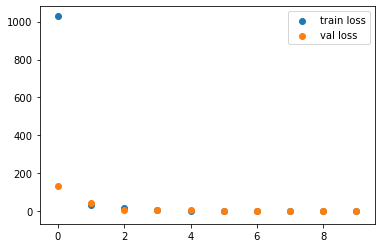

In [8]:
f, ax = plt.subplots()
ax.scatter(range(len(losses)), losses, label='train loss')
ax.scatter(range(len(val_losses)), val_losses, label='val loss')
plt.legend(loc='upper right');

## Testing the model

Optimally, MAT should be trained for a lot more epochs with a GPU. Due to computational constraints, we train this model for very few epochs in this tutorial. Let us now see how to predict the hydration enthalpy values for molecues now with MAT.

In [10]:
# We will be predicting the enthalpy value for the smile string we featurized earlier in the MATFeaturizer section.
model.predict_on_batch(output)

array([[4.167216]], dtype=float32)